In [1]:
import pyemu
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import geostat_helpers as gh
import pandas as pd

## `pyemu` supports three variogram models

This follows the _GSLIB_ terminology

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  

     

$h$ is the separation distance, and $a$ is the range. `contribution` is the variogram value at which the variogram levels off. Also called the `sill`, this value is the maximum variability between points.

The sill is reached at about $a$ for the *Spherical* model, $2a$ for the *Gaussian*, and $3a$ for the *Exponential*

In [2]:
contribution=100.0
a=350.0
v = pyemu.geostats.GauVario(contribution=contribution,a=a)
gs = pyemu.geostats.GeoStruct(variograms=v)

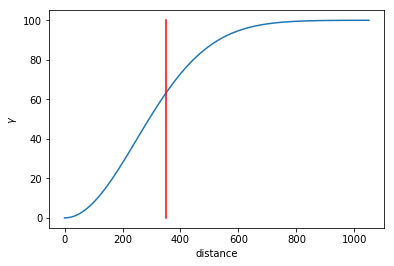

In [3]:
ax = gs.plot()
plt.plot([a,a],[0, contribution], 'r')

# make a quick spatial domain

In [4]:
x = np.linspace(1,1000,50)
y = x.copy()
X,Y = np.meshgrid(x,y)

## also set up a few points at which to sample

In [5]:

npts = 100
xd = np.random.uniform(0,1000, 100)
yd = np.random.uniform(0,1000, 100)
names = ['p{0}'.format(i) for i in range(npts)]
sample_df = pd.DataFrame({'x':xd,'y':yd,'name': names})

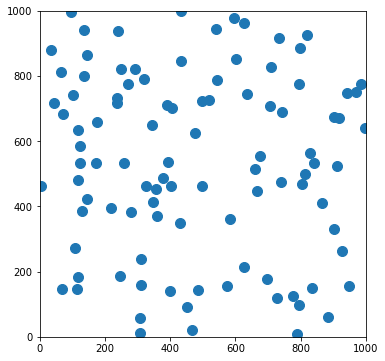

In [6]:
gh.field_scatterplot(xd,yd)


# we can create a covariance matrix from these points and the structure

In [7]:
Q=gs.covariance_matrix(X.ravel(),Y.ravel(),names=[str(i) for i in range(len(Y.ravel()))])

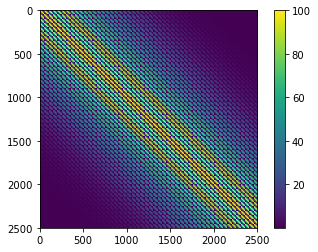

In [8]:
plt.imshow(Q.x)
plt.colorbar()
plt.show()

In [9]:
d = Q.draw(mean=100).reshape(X.shape)

/Users/mnfienen/Documents/GIT/pyemu/pyemu/mat/mat_handler.py:1638: RuntimeWarning: covariance is not positive-semidefinite.
  return(np.random.multivariate_normal(mean, self.as_2d))


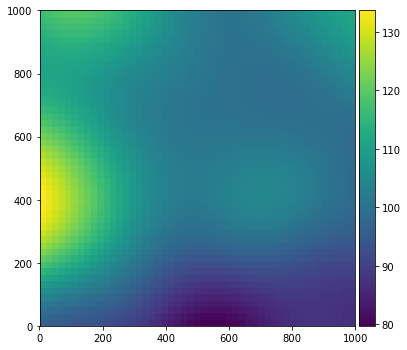

In [10]:
gh.grid_plot(X,Y,d)

In [11]:
zd = gh.sample_from_grid(X,Y,d,xd,yd)
sample_df['zd'] = zd

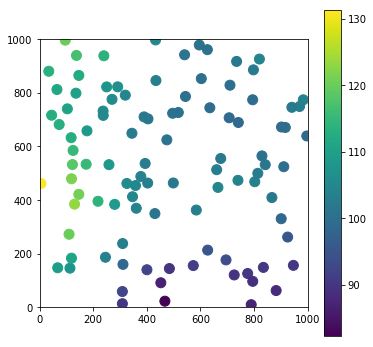

In [12]:
gh.field_scatterplot(xd,yd,zd)

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


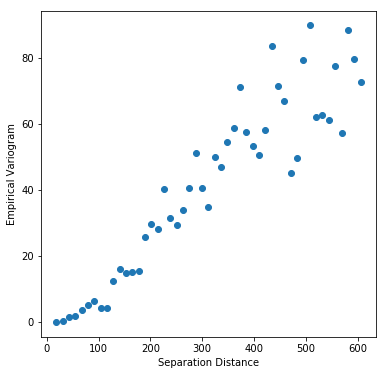

In [13]:
h,gam,ax=gh.plot_empirical_variogram(xd,yd,zd,50)

# Now we can try and fit a variogram to these data

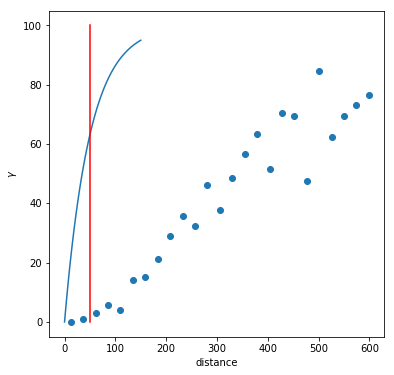

In [14]:
h,gam,ax=gh.plot_empirical_variogram(xd,yd,zd,25)
new_c=100.0
new_a=50.0

v_fit = pyemu.geostats.ExpVario(contribution=new_c,a=new_a)
gs_fit = pyemu.geostats.GeoStruct(variograms=v_fit)
gs_fit.plot(ax=ax)
plt.plot([new_a,new_a],[0, new_c], 'r')

# We can perform Kriging to interpolate using this variogram and our "data"

### First make an Ordinary Kriging object

In [15]:
k = pyemu.geostats.OrdinaryKrige(gs_fit,sample_df)

In [16]:
kfactors = k.calc_factors(X.ravel(),Y.ravel())

starting interp point loop for 2500 points
took 7.853975 seconds


In [17]:
Z_interp = gh.geostat_interpolate(X,Y,k.interp_data, sample_df)

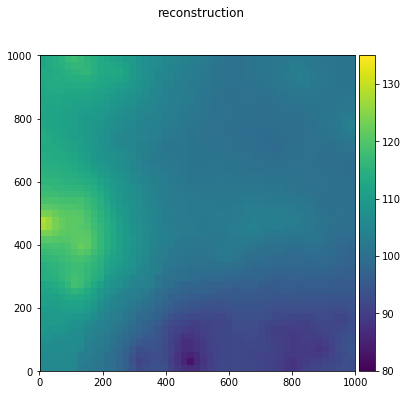

In [18]:
gh.grid_plot(X,Y,Z_interp,vlims=[80,135], title='reconstruction')

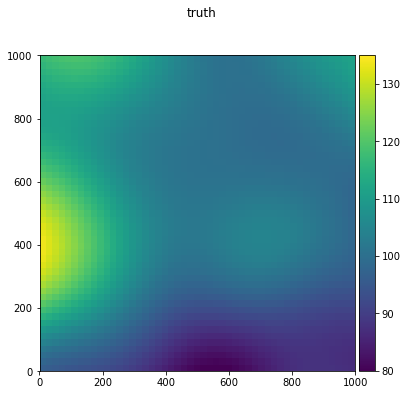

In [19]:
gh.grid_plot(X,Y,d,vlims=[80,135],title='truth')